## Exploring the results of our experiments
In this notebook we are going to explore the results from our experiment
- Baseline: regex for matching CVEIDs
- GPT classifier: 0-shot classification task using GPT
- Text embedding + XGBoost

In [2]:
from dotenv import load_dotenv
import os

os.chdir("..")
os.getcwd()
load_dotenv()

print(os.getcwd())

/Users/daniele/rise/Thesis-daniele/Vulnerability_prediction


## GPT classifier zero-shot learning GPT4o-mini

In [10]:
from datasets import load_dataset

test = load_dataset("DanCip/github-issues-vul-detection-gpt-zero-results", split='test')
gpt_zero_test_df = test.to_pandas()

In [11]:
import re

def extract_base_severity(payload):
    if payload is None:
        return None
    
    match = re.search(r"'impactScore'\s*:\s*([0-9\.]+)", str(payload))
    if match:
        return float(match.group(1))
    else:
        return None
    
gpt_zero_test_df['cvssV2_impactScore'] = gpt_zero_test_df.cve_metrics.map(extract_base_severity)

In [12]:
from sklearn.metrics import accuracy_score, classification_report

y_test = gpt_zero_test_df.label.values
y_pred = gpt_zero_test_df.gpt_is_relevant

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7751141552511416
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.72      0.84      1414
        True       0.46      0.99      0.63       338

    accuracy                           0.78      1752
   macro avg       0.73      0.86      0.73      1752
weighted avg       0.89      0.78      0.80      1752



correct
0    int64
1    int64
dtype: object


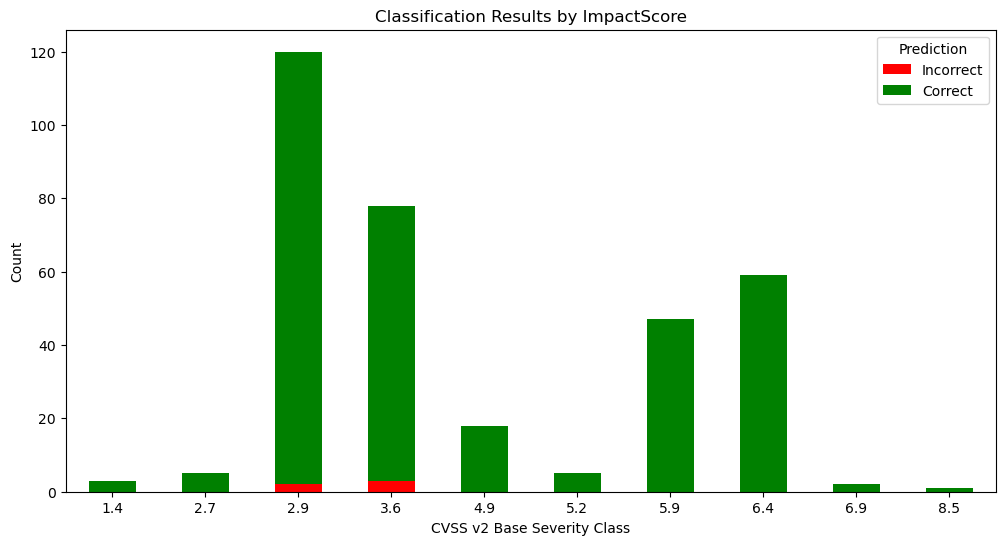

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

 # Create DataFrame with necessary information
results_df = pd.DataFrame({
    'class': gpt_zero_test_df.cvssV2_impactScore,
    'correct': y_pred == y_test,
})
results_df['correct'] = results_df['correct'].astype(int)

# Group by class and correctness, count occurrences
grouped_results = results_df.groupby(['class', 'correct']).size().unstack(fill_value=0)

# Ensure that the data in grouped_results is numeric
print(grouped_results.dtypes)

# Plot
grouped_results.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.xlabel('CVSS v2 Base Severity Class') 
plt.ylabel('Count') 
plt.title('Classification Results by ImpactScore') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
#plt.tight_layout() 
plt.show()

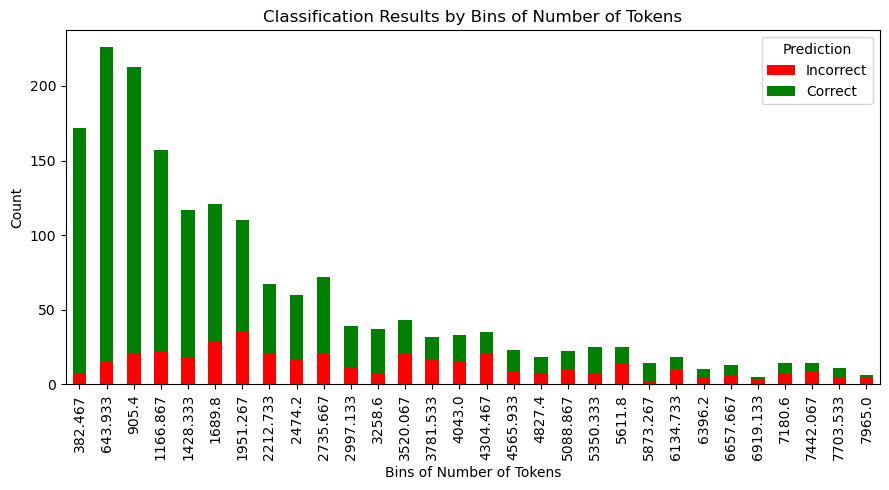

In [14]:
from operator import attrgetter 
bins = pd.cut(gpt_zero_test_df.issue_msg_n_tokens, bins=30) 

results_df = pd.DataFrame({
    'bins': bins,
    'correct': y_pred == y_test
}) 
results_df['bins'] = results_df['bins'].map(attrgetter('right'))
grouped_results = results_df.groupby(['bins', 'correct']).size().unstack(fill_value=0)   
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['red', 'green'])
plt.xlabel('Bins of Number of Tokens') 
plt.ylabel('Count') 
plt.title('Classification Results by Bins of Number of Tokens') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show() 

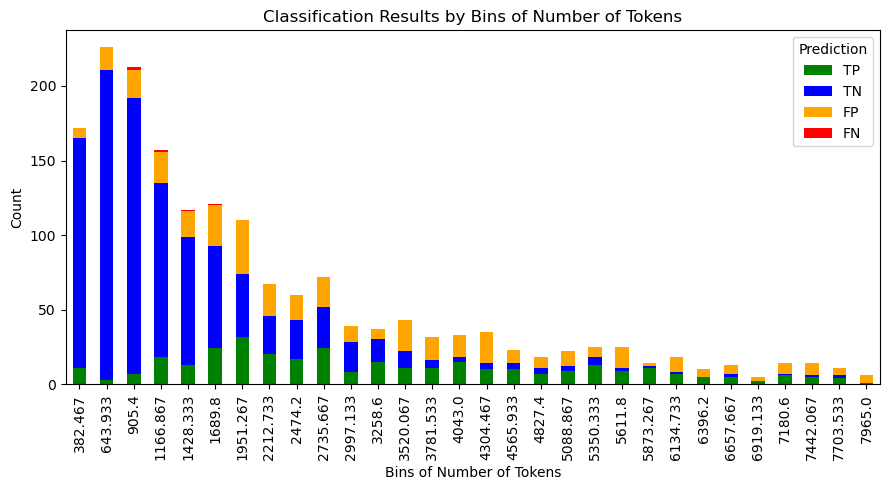

In [15]:
from operator import attrgetter

bins = pd.cut(gpt_zero_test_df.issue_msg_n_tokens, bins=30)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'bins': bins.map(attrgetter('right')),
    'TP': y_pred & y_test,
    'TN':  ((~y_pred) & (~y_test)),
    'FP':  (y_pred & (~y_test)),
    'FN':  ((~y_pred) & y_test)
})
# Group the results by the bins
grouped_results = results_df.groupby('bins').sum()

# Plot the stacked bar chart
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['green', 'blue', 'orange', 'red'])

plt.xlabel('Bins of Number of Tokens')
plt.ylabel('Count')
plt.title('Classification Results by Bins of Number of Tokens')
plt.legend(['TP', 'TN', 'FP', 'FN'], title='Prediction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
import numpy as np

TP = np.logical_and(y_pred == 1, y_test == 1)
TN = np.logical_and(y_pred == 0, y_test == 0)
FP = np.logical_and(y_pred == 1, y_test == 0)
FN = np.logical_and(y_pred == 0, y_test == 1)

print("Zero-shot")
print("Count of True Positives (TP):", np.sum(TP))
print("Count of True Negatives (TN):", np.sum(TN))
print("Count of False Positives (FP):", np.sum(FP))
print("Count of False Negatives (FN):", np.sum(FN))

Zero-shot
Count of True Positives (TP): 333
Count of True Negatives (TN): 1025
Count of False Positives (FP): 389
Count of False Negatives (FN): 5


## GPT classifier few-shot learning GPT4o-mini

In [2]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-gpt-few-strict-vul-desc-results", split='test')
gpt_few_test_df = test.to_pandas()

In [18]:
import re

def extract_base_severity(payload):
    if payload is None:
        return None
    
    match = re.search(r"'impactScore'\s*:\s*([0-9\.]+)", str(payload))
    if match:
        return float(match.group(1))
    else:
        return None
    
gpt_few_test_df['cvssV2_impactScore'] = gpt_few_test_df.cve_metrics.map(extract_base_severity)

In [3]:
from sklearn.metrics import accuracy_score, classification_report

y_test = gpt_few_test_df.label.values
y_pred = gpt_few_test_df.gpt_is_relevant

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8172103487064117
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.79      0.88      1457
        True       0.50      0.95      0.65       321

    accuracy                           0.82      1778
   macro avg       0.74      0.87      0.76      1778
weighted avg       0.90      0.82      0.84      1778



correct
0    int64
1    int64
dtype: object


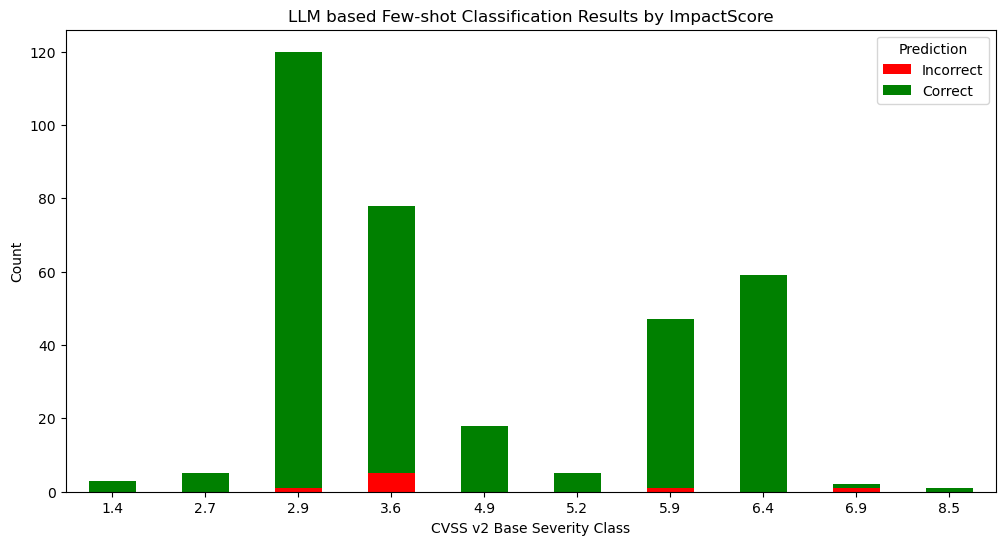

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

 # Create DataFrame with necessary information
results_df = pd.DataFrame({
    'class': gpt_few_test_df.cvssV2_impactScore,
    'correct': y_pred == y_test,
})
results_df['correct'] = results_df['correct'].astype(int)

# Group by class and correctness, count occurrences
grouped_results = results_df.groupby(['class', 'correct']).size().unstack(fill_value=0)

# Ensure that the data in grouped_results is numeric
print(grouped_results.dtypes)

# Plot
grouped_results.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.xlabel('CVSS v2 Base Severity Class') 
plt.ylabel('Count') 
plt.title('LLM based Few-shot Classification Results by ImpactScore') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
#plt.tight_layout() 
plt.show()

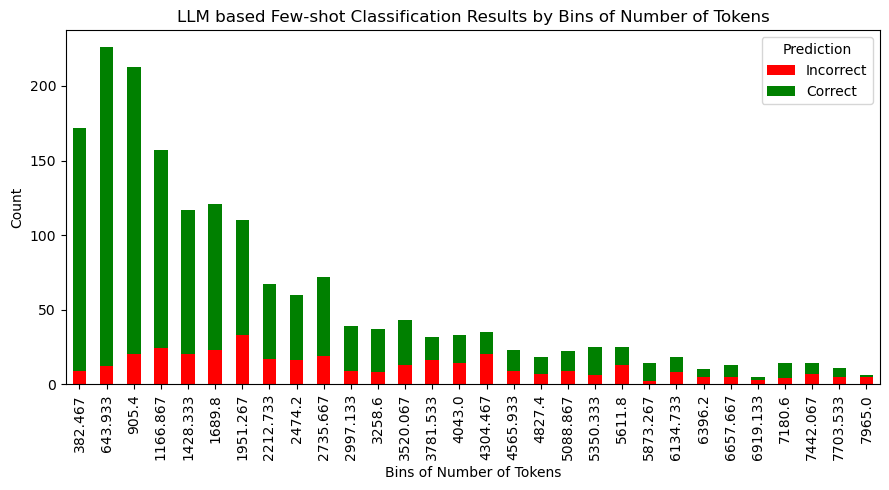

In [21]:
from operator import attrgetter 
bins = pd.cut(gpt_few_test_df.issue_msg_n_tokens, bins=30) 

results_df = pd.DataFrame({
    'bins': bins,
    'correct': y_pred == y_test
}) 
results_df['bins'] = results_df['bins'].map(attrgetter('right'))
grouped_results = results_df.groupby(['bins', 'correct']).size().unstack(fill_value=0)   
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['red', 'green'])
plt.xlabel('Bins of Number of Tokens') 
plt.ylabel('Count') 
plt.title('LLM based Few-shot Classification Results by Bins of Number of Tokens') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show() 

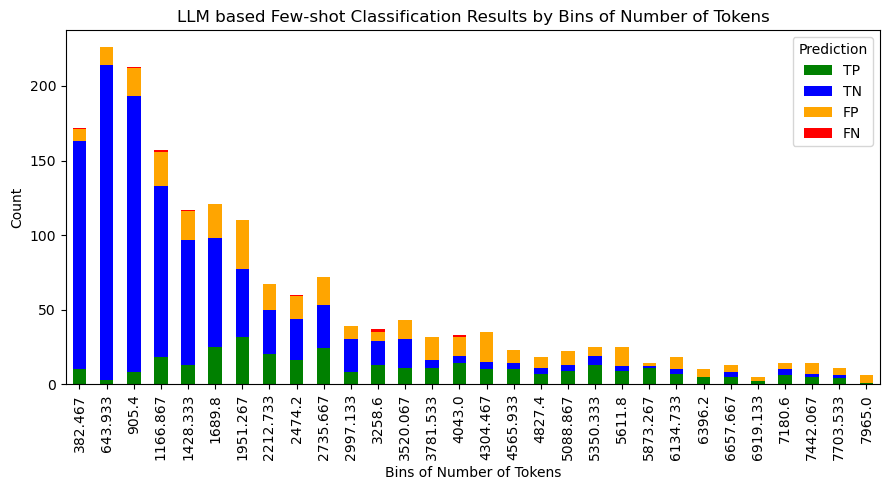

In [22]:
from operator import attrgetter

bins = pd.cut(gpt_few_test_df.issue_msg_n_tokens, bins=30)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'bins': bins.map(attrgetter('right')),
    'TP': y_pred & y_test,
    'TN':  ((~y_pred) & (~y_test)),
    'FP':  (y_pred & (~y_test)),
    'FN':  ((~y_pred) & y_test)
})
results_few_df = results_df.copy()
# Group the results by the bins
grouped_results = results_df.groupby('bins').sum()

# Plot the stacked bar chart
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['green', 'blue', 'orange', 'red'])

plt.xlabel('Bins of Number of Tokens')
plt.ylabel('Count')
plt.title('LLM based Few-shot Classification Results by Bins of Number of Tokens')
plt.legend(['TP', 'TN', 'FP', 'FN'], title='Prediction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
import numpy as np

TP = np.logical_and(y_pred == 1, y_test == 1)
TN = np.logical_and(y_pred == 0, y_test == 0)
FP = np.logical_and(y_pred == 1, y_test == 0)
FN = np.logical_and(y_pred == 0, y_test == 1)

print("Few-shot")
print("Count of True Positives (TP):", np.sum(TP))
print("Count of True Negatives (TN):", np.sum(TN))
print("Count of False Positives (FP):", np.sum(FP))
print("Count of False Negatives (FN):", np.sum(FN))
len(y_test)

Few-shot
Count of True Positives (TP): 306
Count of True Negatives (TN): 1147
Count of False Positives (FP): 310
Count of False Negatives (FN): 15


1778

## Embedding classifier 

In [5]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-xgb-results", split='test')
emb_test_df = test.to_pandas()

README.md:   0%|          | 0.00/7.22k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1778 [00:00<?, ? examples/s]

In [26]:
import re

def extract_base_severity(payload):
    if payload is None:
        return None
    
    match = re.search(r"'impactScore'\s*:\s*([0-9\.]+)", str(payload))
    if match:
        return float(match.group(1))
    else:
        return None
    
emb_test_df['cvssV2_impactScore'] = emb_test_df.cve_metrics.map(extract_base_severity)

In [6]:
from sklearn.metrics import accuracy_score, classification_report

y_test = emb_test_df.label.values
y_pred = emb_test_df.xgb_prediction.values

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8830146231721034
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.89      0.93      1457
        True       0.63      0.83      0.72       321

    accuracy                           0.88      1778
   macro avg       0.80      0.86      0.82      1778
weighted avg       0.90      0.88      0.89      1778



correct
0    int64
1    int64
dtype: object


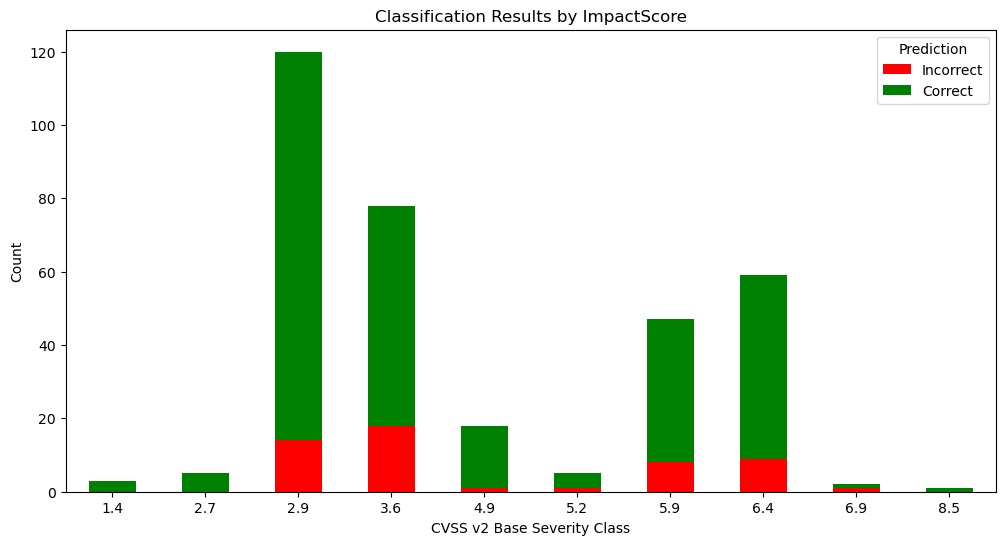

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

 # Create DataFrame with necessary information
results_df = pd.DataFrame({
    'class': emb_test_df.cvssV2_impactScore,
    'correct': y_pred == y_test
})
results_df['correct'] = results_df['correct'].astype(int)

# Group by class and correctness, count occurrences
grouped_results = results_df.groupby(['class', 'correct']).size().unstack(fill_value=0)

# Ensure that the data in grouped_results is numeric
print(grouped_results.dtypes)

# Plot
grouped_results.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.xlabel('CVSS v2 Base Severity Class') 
plt.ylabel('Count') 
plt.title('Classification Results by ImpactScore') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
#plt.tight_layout() 
plt.show()

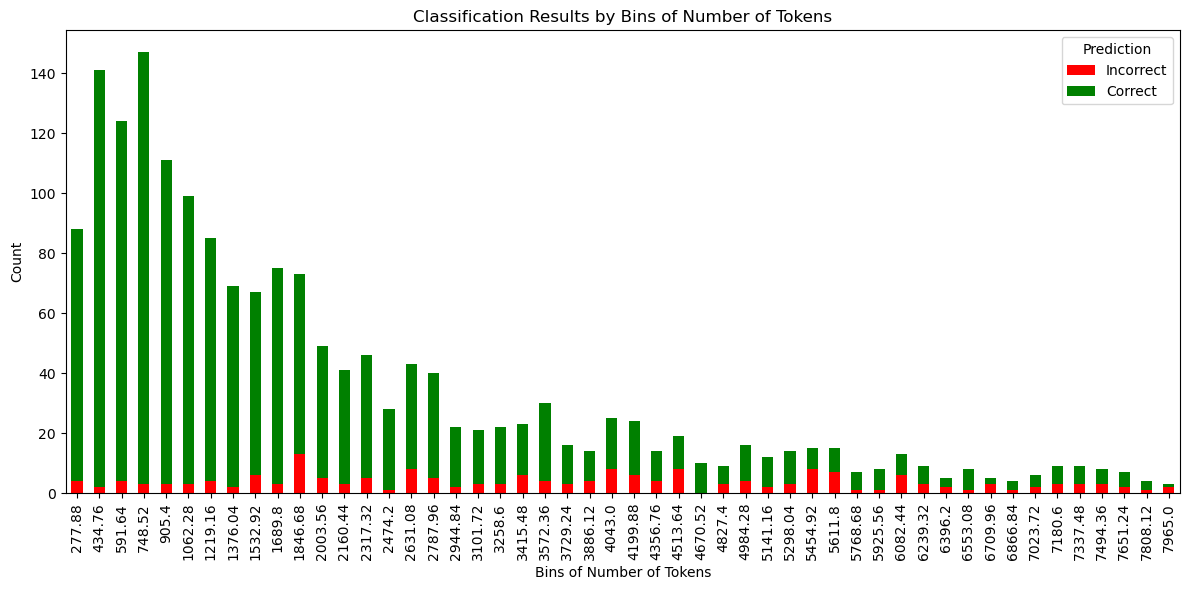

In [29]:
from operator import attrgetter 
bins = pd.cut(emb_test_df.issue_msg_n_tokens, bins=50) 

results_df = pd.DataFrame({
    'bins': bins,
    'correct': y_pred == y_test
}) 
results_df['bins'] = results_df['bins'].map(attrgetter('right'))
grouped_results = results_df.groupby(['bins', 'correct']).size().unstack(fill_value=0)   
grouped_results.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.xlabel('Bins of Number of Tokens') 
plt.ylabel('Count') 
plt.title('Classification Results by Bins of Number of Tokens') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.grid(False)
plt.show() 

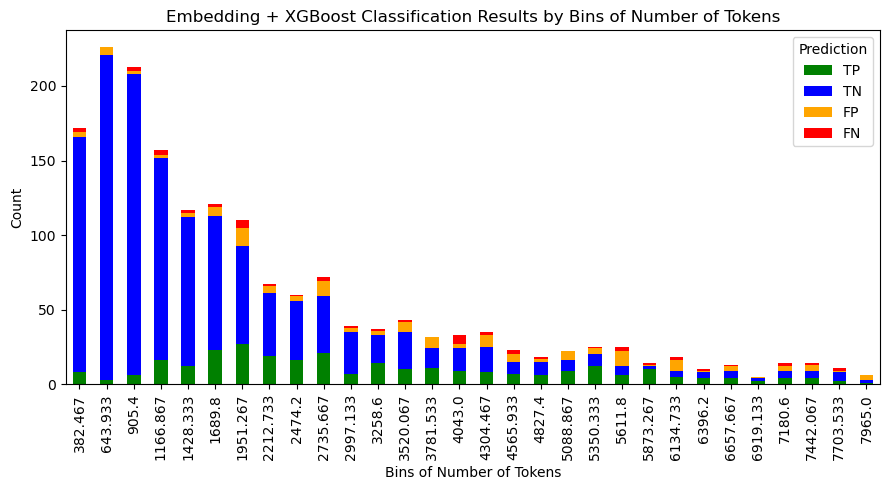

In [30]:
from operator import attrgetter

bins = pd.cut(emb_test_df.issue_msg_n_tokens, bins=30)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'bins': bins.map(attrgetter('right')),
    'TP': y_pred & y_test,
    'TN':  ((~y_pred) & (~y_test)),
    'FP':  (y_pred & (~y_test)),
    'FN':  ((~y_pred) & y_test)
})
# Group the results by the bins
grouped_results = results_df.groupby('bins').sum()

# Plot the stacked bar chart
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['green', 'blue', 'orange', 'red'])

plt.xlabel('Bins of Number of Tokens')
plt.ylabel('Count')
plt.title('Embedding + XGBoost Classification Results by Bins of Number of Tokens')
plt.legend(['TP', 'TN', 'FP', 'FN'], title='Prediction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

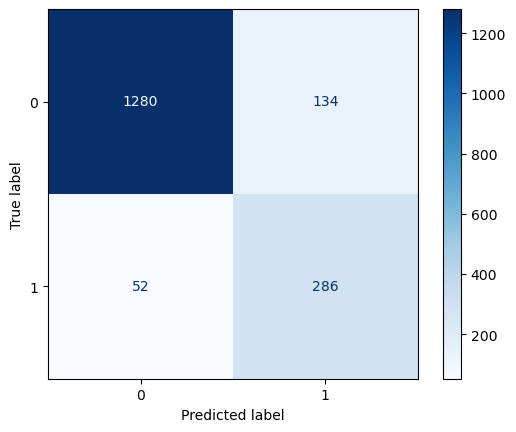

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## GPT + embedding classifier

In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_test = emb_test_df.label.values
y_pred = emb_test_df.xgb_prediction&gpt_few_test_df.gpt_is_relevant

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.889763779527559
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.91      0.93      1457
        True       0.66      0.81      0.73       321

    accuracy                           0.89      1778
   macro avg       0.81      0.86      0.83      1778
weighted avg       0.90      0.89      0.89      1778



correct
0    int64
1    int64
dtype: object


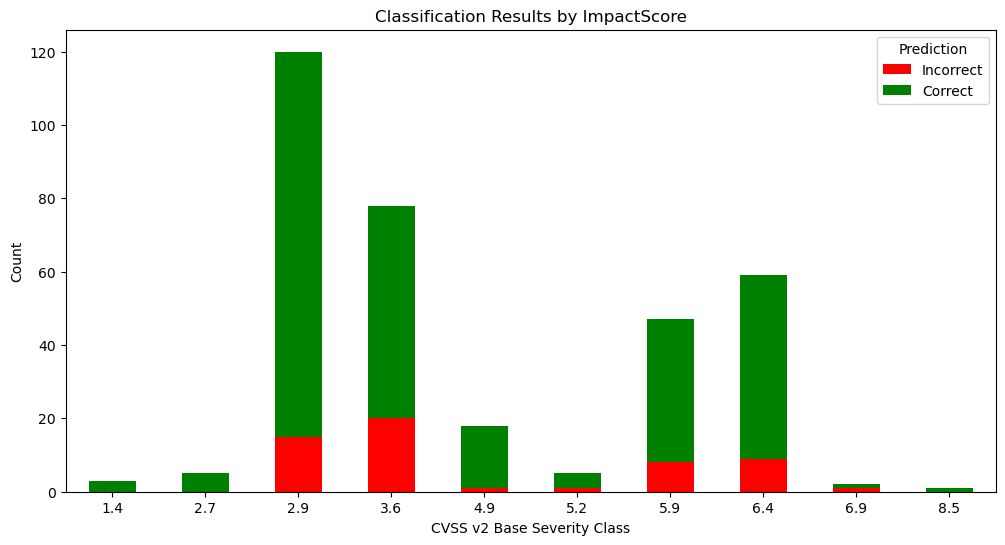

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

 # Create DataFrame with necessary information
results_df = pd.DataFrame({
    'class': emb_test_df.cvssV2_impactScore,
    'correct': y_pred == y_test
})
results_df['correct'] = results_df['correct'].astype(int)

# Group by class and correctness, count occurrences
grouped_results = results_df.groupby(['class', 'correct']).size().unstack(fill_value=0)

# Ensure that the data in grouped_results is numeric
print(grouped_results.dtypes)

# Plot
grouped_results.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.xlabel('CVSS v2 Base Severity Class') 
plt.ylabel('Count') 
plt.title('Classification Results by ImpactScore') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
#plt.tight_layout() 
plt.show()

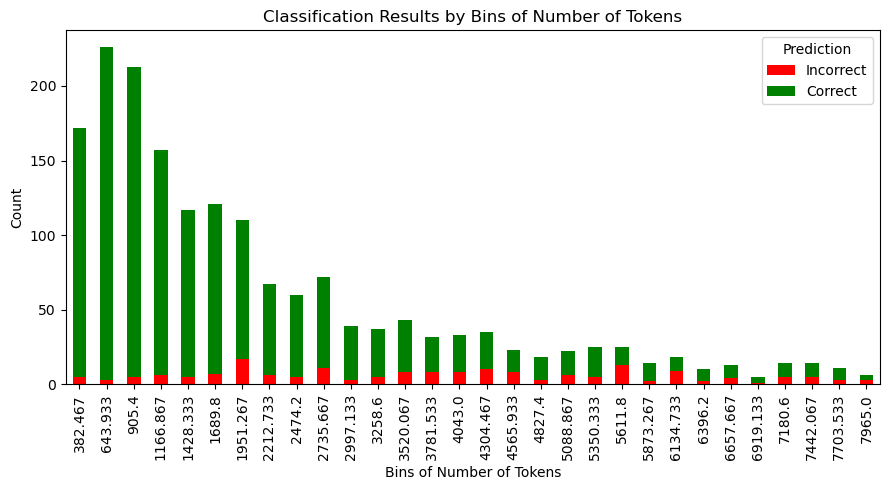

In [34]:
from operator import attrgetter 
bins = pd.cut(emb_test_df.issue_msg_n_tokens, bins=30) 

results_df = pd.DataFrame({
    'bins': bins,
    'correct': y_pred == y_test
}) 
results_df['bins'] = results_df['bins'].map(attrgetter('right'))
grouped_results = results_df.groupby(['bins', 'correct']).size().unstack(fill_value=0)   
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['red', 'green'])
plt.xlabel('Bins of Number of Tokens') 
plt.ylabel('Count') 
plt.title('Classification Results by Bins of Number of Tokens') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show() 

In [12]:
import numpy as np

TP = np.logical_and(y_pred == 1, y_test == 1)
TN = np.logical_and(y_pred == 0, y_test == 0)
FP = np.logical_and(y_pred == 1, y_test == 0)
FN = np.logical_and(y_pred == 0, y_test == 1)

print("Few-shot")
print("Count of True Positives (TP):", np.sum(TP))
print("Count of True Negatives (TN):", np.sum(TN))
print("Count of False Positives (FP):", np.sum(FP))
print("Count of False Negatives (FN):", np.sum(FN))
len(y_test)

Few-shot
Count of True Positives (TP): 260
Count of True Negatives (TN): 1322
Count of False Positives (FP): 135
Count of False Negatives (FN): 61


1778

/tmp/ipykernel_67450/1538279749.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_results = results_df.groupby('bins').sum()


NameError: name 'plt' is not defined

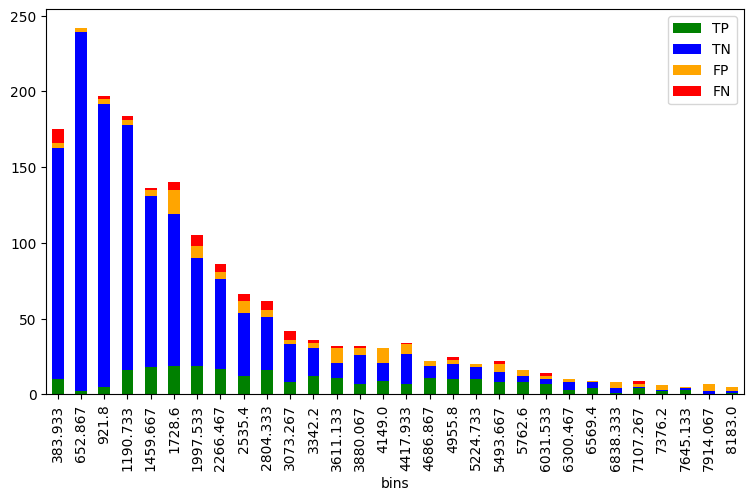

In [10]:
import pandas as pd
from operator import attrgetter

bins = pd.cut(emb_test_df.issue_msg_n_tokens, bins=30)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'bins': bins.map(attrgetter('right')),
    'TP': y_pred & y_test,
    'TN':  ((~y_pred) & (~y_test)),
    'FP':  (y_pred & (~y_test)),
    'FN':  ((~y_pred) & y_test)
})
# Group the results by the bins
grouped_results = results_df.groupby('bins').sum()

# Plot the stacked bar chart
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['green', 'blue', 'orange', 'red'])

plt.xlabel('Bins of Number of Tokens')
plt.ylabel('Count')
plt.title('Combined Classification Results by Bins of Number of Tokens')
plt.legend(['TP', 'TN', 'FP', 'FN'], title='Prediction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

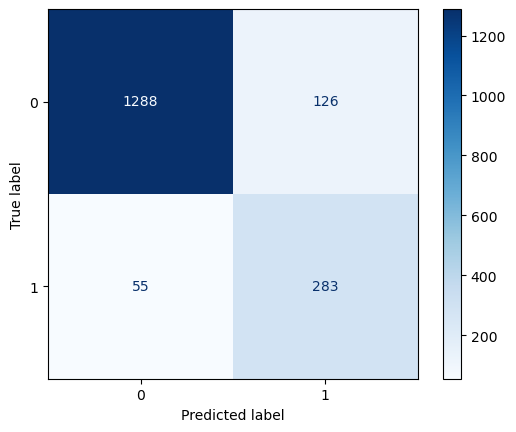

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

# GPT + embedding classifier (post Cutoff)

In [11]:
from datasets import load_dataset
import pandas as pd 
import datetime

test = load_dataset("DanCip/github-issues-vul-detection-xgb-results", split='test')
emb_test_df = test.to_pandas()

# Filtering for date
emb_test_df['cve_published'] = pd.to_datetime(emb_test_df['cve_published'], format="%Y-%m-%dT%H:%M:%S.%f")
emb_test_df['issue_created_at'] = pd.to_datetime(emb_test_df['issue_created_at'], format="%Y-%m-%dT%H:%M:%S.%f")

cutoff_date = datetime.datetime(2023, 11, 1)

emb_test_df = emb_test_df[(emb_test_df.issue_created_at>cutoff_date)|(emb_test_df.cve_published>cutoff_date)]

In [12]:
from datasets import load_dataset

test = load_dataset("DanCip/github-issues-vul-detection-gpt-few-results", split='test')
gpt_few_test_df = test.to_pandas()

# Filtering for date
gpt_few_test_df['cve_published'] = pd.to_datetime(gpt_few_test_df['cve_published'], format="%Y-%m-%dT%H:%M:%S.%f")
gpt_few_test_df['issue_created_at'] = pd.to_datetime(gpt_few_test_df['issue_created_at'], format="%Y-%m-%dT%H:%M:%S.%f")

cutoff_date = datetime.datetime(2023, 11, 1)

gpt_few_test_df = gpt_few_test_df[(gpt_few_test_df.issue_created_at>cutoff_date)|(gpt_few_test_df.cve_published>cutoff_date)]

In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_test = emb_test_df.label.values
y_pred = emb_test_df.xgb_prediction&gpt_few_test_df.gpt_is_relevant

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9443651925820257
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.97       672
        True       0.41      0.83      0.55        29

    accuracy                           0.94       701
   macro avg       0.70      0.89      0.76       701
weighted avg       0.97      0.94      0.95       701



correct
0    int64
1    int64
dtype: object


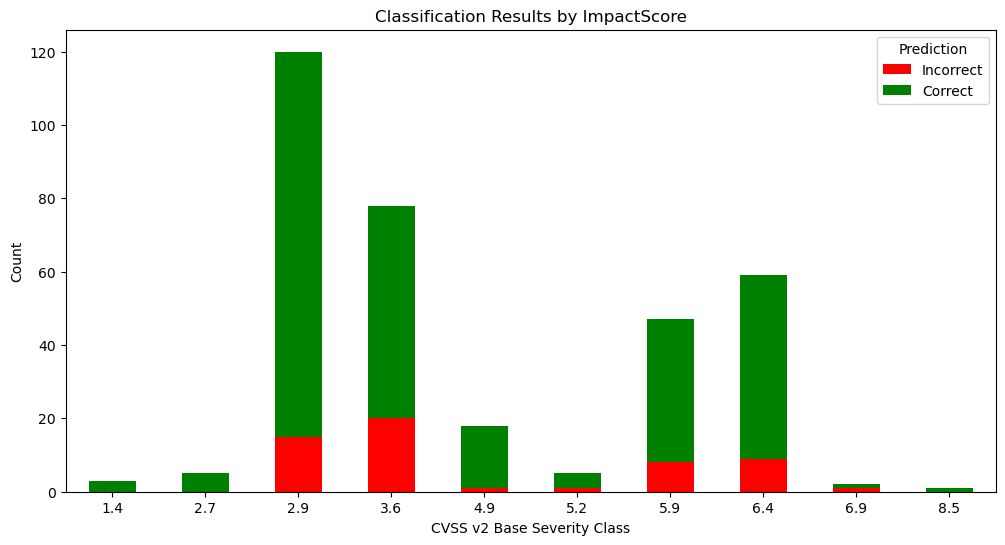

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

 # Create DataFrame with necessary information
results_df = pd.DataFrame({
    'class': emb_test_df.cvssV2_impactScore,
    'correct': y_pred == y_test
})
results_df['correct'] = results_df['correct'].astype(int)

# Group by class and correctness, count occurrences
grouped_results = results_df.groupby(['class', 'correct']).size().unstack(fill_value=0)

# Ensure that the data in grouped_results is numeric
print(grouped_results.dtypes)

# Plot
grouped_results.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.xlabel('CVSS v2 Base Severity Class') 
plt.ylabel('Count') 
plt.title('Classification Results by ImpactScore') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
#plt.tight_layout() 
plt.show()

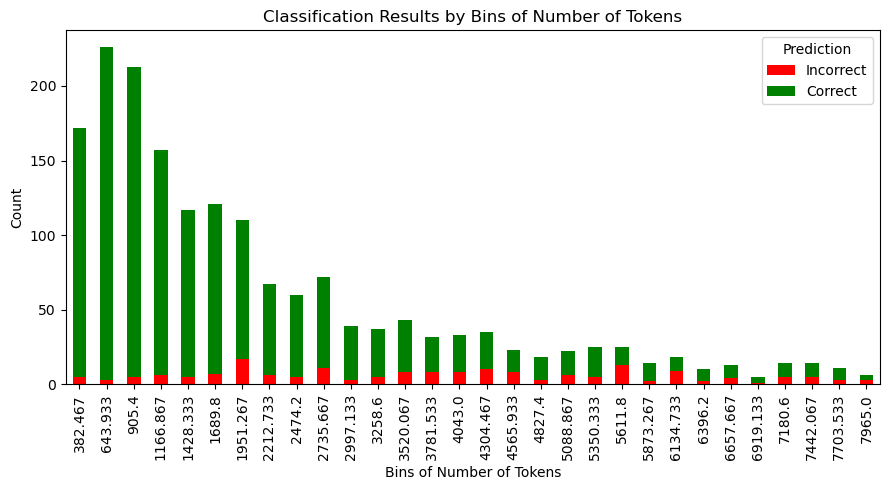

In [34]:
from operator import attrgetter 
bins = pd.cut(emb_test_df.issue_msg_n_tokens, bins=30) 

results_df = pd.DataFrame({
    'bins': bins,
    'correct': y_pred == y_test
}) 
results_df['bins'] = results_df['bins'].map(attrgetter('right'))
grouped_results = results_df.groupby(['bins', 'correct']).size().unstack(fill_value=0)   
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['red', 'green'])
plt.xlabel('Bins of Number of Tokens') 
plt.ylabel('Count') 
plt.title('Classification Results by Bins of Number of Tokens') 
plt.legend(['Incorrect', 'Correct'], title='Prediction') 
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show() 

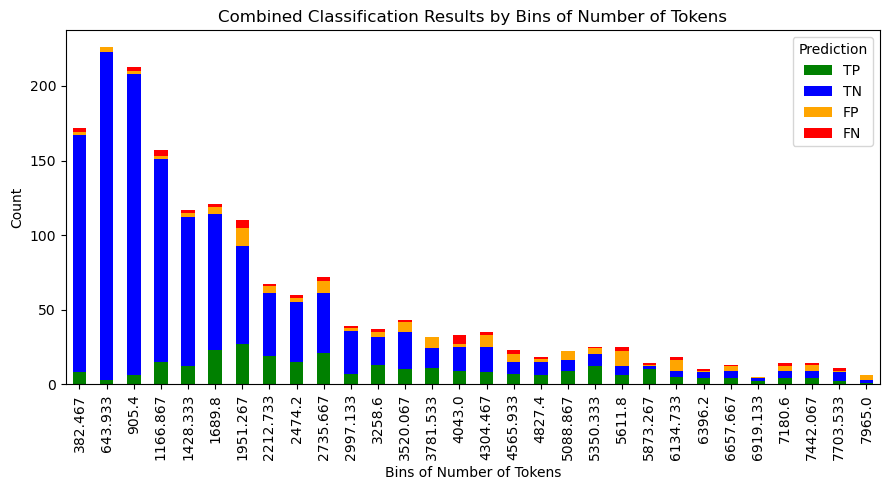

In [38]:
from operator import attrgetter

bins = pd.cut(emb_test_df.issue_msg_n_tokens, bins=30)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'bins': bins.map(attrgetter('right')),
    'TP': y_pred & y_test,
    'TN':  ((~y_pred) & (~y_test)),
    'FP':  (y_pred & (~y_test)),
    'FN':  ((~y_pred) & y_test)
})
# Group the results by the bins
grouped_results = results_df.groupby('bins').sum()

# Plot the stacked bar chart
grouped_results.plot(kind='bar', stacked=True, figsize=(9, 5), color=['green', 'blue', 'orange', 'red'])

plt.xlabel('Bins of Number of Tokens')
plt.ylabel('Count')
plt.title('Combined Classification Results by Bins of Number of Tokens')
plt.legend(['TP', 'TN', 'FP', 'FN'], title='Prediction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

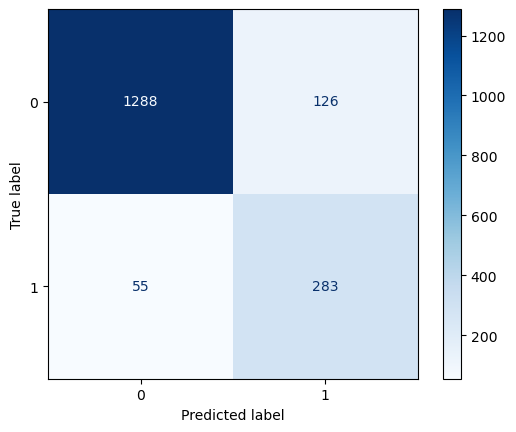

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')